In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [202]:
df = pd.read_csv('performance_results.csv')
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,url,screenshotpath,run
0,754 ms,2334 ms,15580 ms,0.147,98 ms,8358,3 KB,1528 ms,312,613,main_page,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_main_page_run1_18-09-43-06...,1
1,923 ms,2731 ms,13076 ms,0.414,19 ms,6423,3 KB,2004 ms,386,748,model_management,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_model_management_run1_18-0...,1
2,671 ms,2343 ms,13016 ms,0.000,122 ms,3412,3 KB,1371 ms,344,265,model_experience,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_model_experience_run1_18-0...,1
3,887 ms,2268 ms,12761 ms,0.322,21 ms,7480,3 KB,1804 ms,406,1724,app_management,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_app_management_run1_18-09-...,1
4,741 ms,2337 ms,17653 ms,0.027,23 ms,7472,3 KB,1738 ms,388,1095,app_experience,https://llmops.transwarp.io/llm/llmops/project...,llmops_transwarp_io_app_experience_run1_18-09-...,1


In [211]:
t_df = df.drop(['screenshotpath', 'run', 'url'], axis=1)
t_df['host'] = df['url'].apply(lambda x: urlparse(x).netloc)
t_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,754 ms,2334 ms,15580 ms,0.147,98 ms,8358,3 KB,1528 ms,312,613,main_page,llmops.transwarp.io
1,923 ms,2731 ms,13076 ms,0.414,19 ms,6423,3 KB,2004 ms,386,748,model_management,llmops.transwarp.io
2,671 ms,2343 ms,13016 ms,0.000,122 ms,3412,3 KB,1371 ms,344,265,model_experience,llmops.transwarp.io
3,887 ms,2268 ms,12761 ms,0.322,21 ms,7480,3 KB,1804 ms,406,1724,app_management,llmops.transwarp.io
4,741 ms,2337 ms,17653 ms,0.027,23 ms,7472,3 KB,1738 ms,388,1095,app_experience,llmops.transwarp.io


In [212]:
def clean_numeric(column):
    if column.dtype == 'object':
        return pd.to_numeric(column.str.replace(r'[^\d.]+', '', regex=True))
    else:
        return column

n_df = t_df.iloc[:, :10].apply(clean_numeric)
n_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements
0,754,2334,15580,0.147,98,8358,3,1528,312,613
1,923,2731,13076,0.414,19,6423,3,2004,386,748
2,671,2343,13016,0.000,122,3412,3,1371,344,265
3,887,2268,12761,0.322,21,7480,3,1804,406,1724
4,741,2337,17653,0.027,23,7472,3,1738,388,1095


In [215]:
scaler = MinMaxScaler()
s_df = pd.DataFrame(
    scaler.fit_transform(n_df),
    columns=t_df.columns[0:10]
)
s_df['pagename'] = t_df['pagename']
s_df['host'] = t_df['host']
s_df.head()

,tbt,fcp,lcp,cls,ttfb,speedindex,pagesize,jsexecutiontime,numberofrequests,numelements,pagename,host
0,0.610667,0.632100,0.827976,0.341860,0.785714,0.815723,1.0,0.445119,0.638462,0.178096,main_page,llmops.transwarp.io
1,0.760889,0.894320,0.647521,0.962791,0.080357,0.543111,1.0,0.707667,0.923077,0.247185,model_management,llmops.transwarp.io
2,0.536889,0.638045,0.643197,0.000000,1.000000,0.118907,1.0,0.358522,0.761538,0.000000,model_experience,llmops.transwarp.io
3,0.728889,0.588507,0.624820,0.748837,0.098214,0.692026,1.0,0.597352,1.000000,0.746673,app_management,llmops.transwarp.io
4,0.599111,0.634082,0.977371,0.062791,0.116071,0.690899,1.0,0.560949,0.930769,0.424770,app_experience,llmops.transwarp.io


In [180]:
# m_df = s_df.melt(id_vars='pagename', var_name='Metric', value_name='Value')
# plt.figure(figsize=(12, 6))
# sns.barplot(data=m_df, x='Metric', y='Value', hue='pagename', dodge=True, errorbar=None)

# plt.xticks(rotation=45)
# plt.title('Relative Comparison of Metrics for Each Page')
# plt.ylabel('Relative Value (Normalized)')
# plt.xlabel('Metrics')

# plt.legend(title='Page Name', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# plt.show()

,pagename,Metric,Value
0,main_page,tbt,0.610667
1,model_management,tbt,0.760889
2,model_experience,tbt,0.536889
3,app_management,tbt,0.728889
4,app_experience,tbt,0.599111


In [216]:
from urllib.parse import urlparse

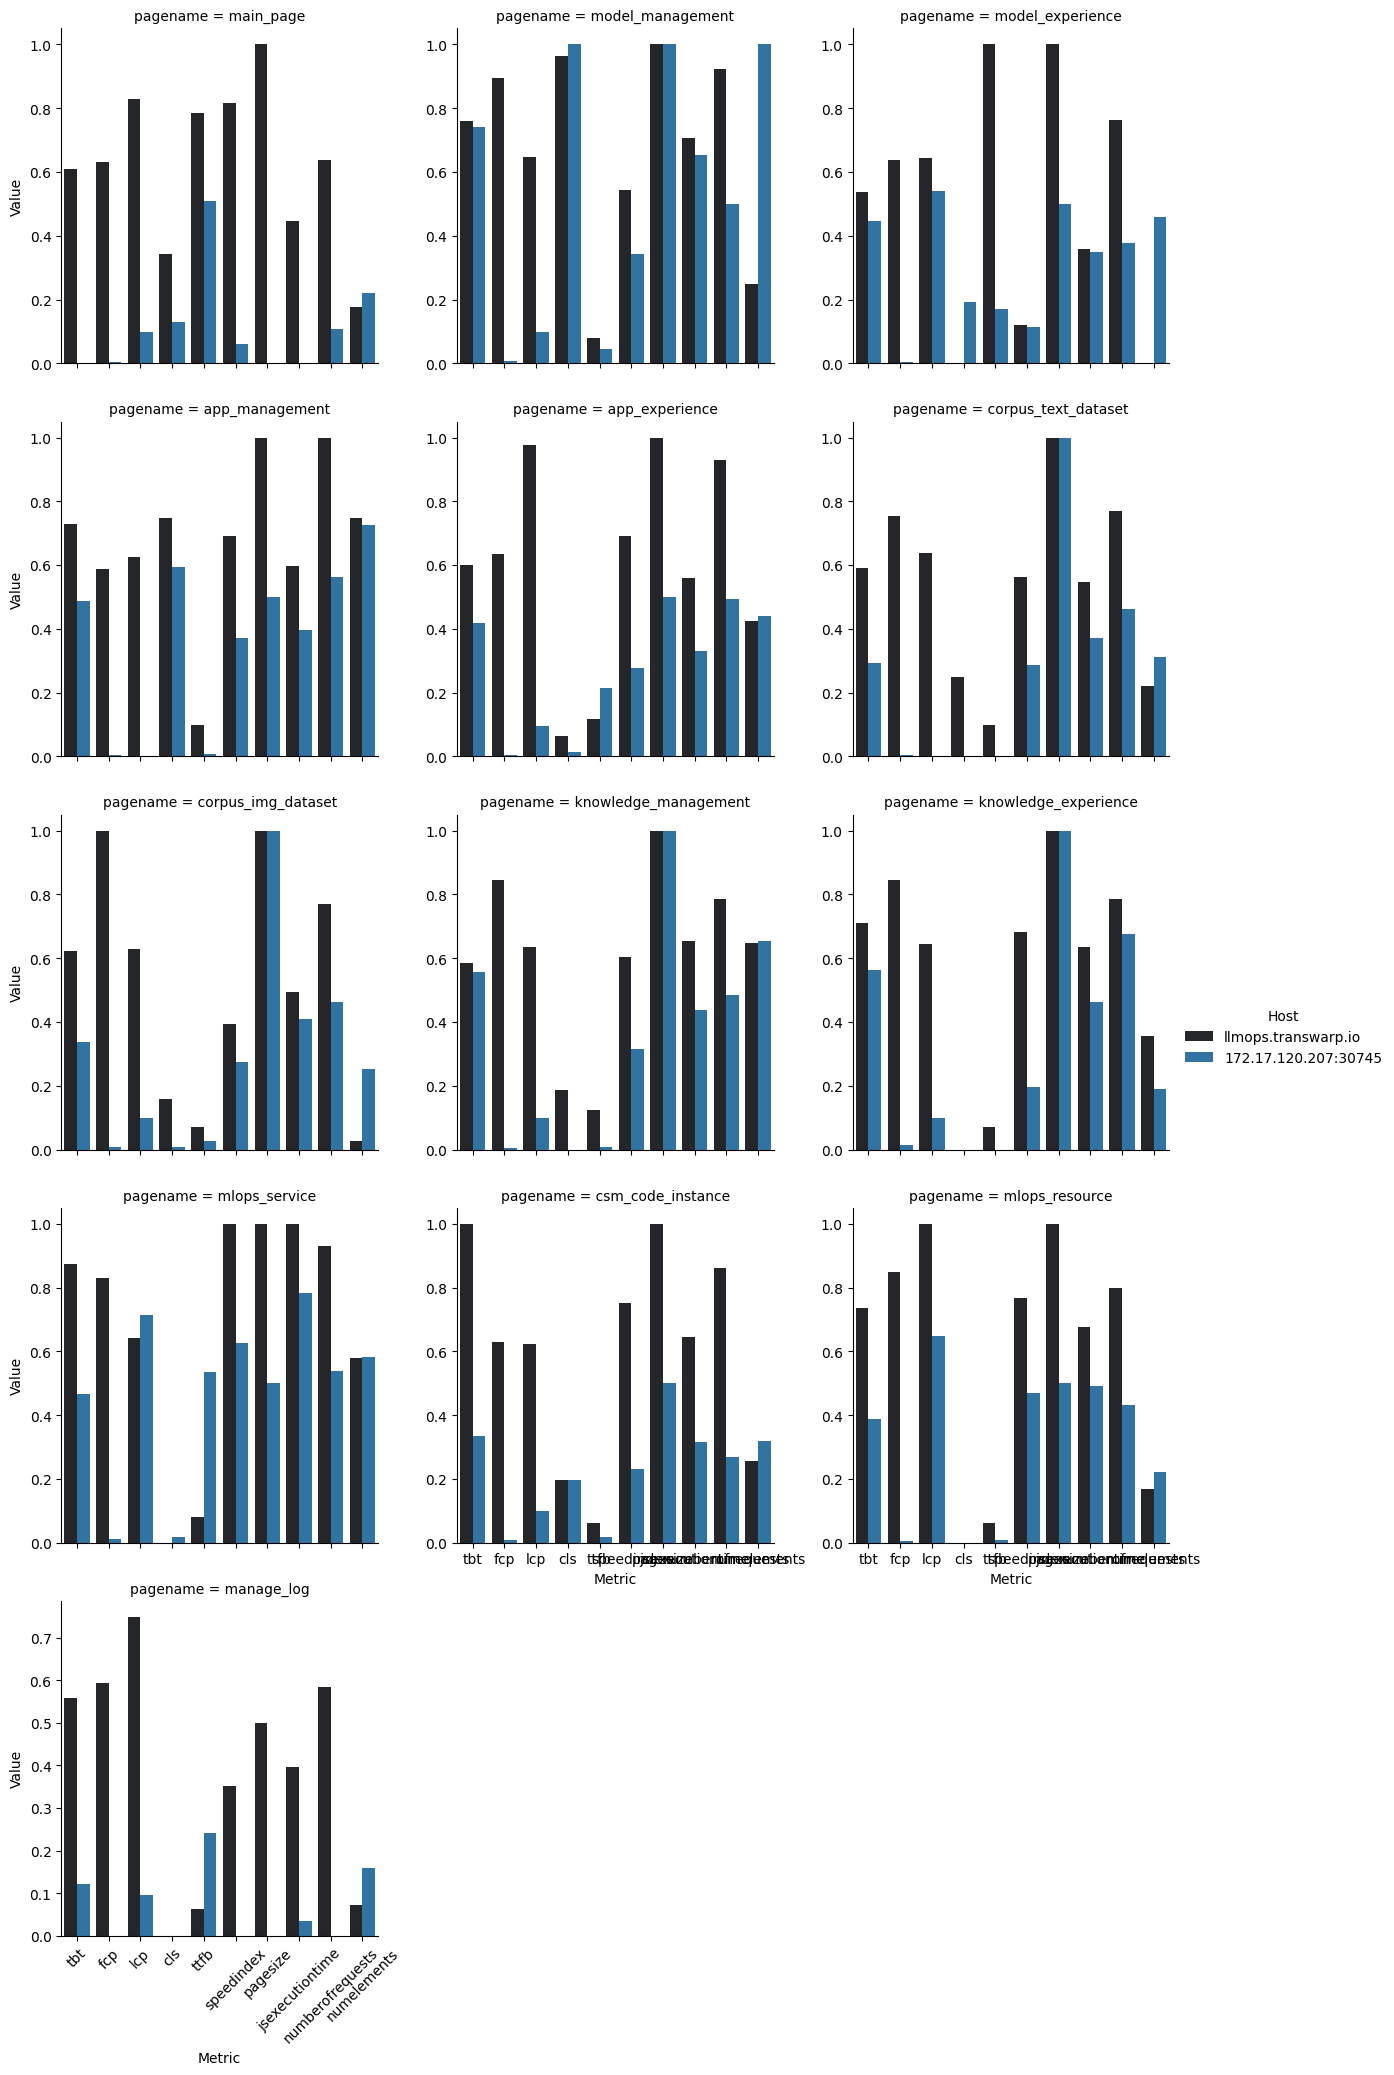

In [218]:
# # 将数据从宽格式转换为长格式
m_df = s_df.melt(id_vars=['pagename', 'host'], var_name='Metric', value_name='Value')
metric_order = m_df['Metric'].unique()
host_order = m_df['host'].unique()

g = sns.FacetGrid(m_df, col='pagename', col_wrap=3, sharey=False, height=4)

# # 在每个子图中绘制 barplot
g.map(sns.barplot, 'Metric', 'Value', 'host', dodge=True, palette='dark:#1f77b4', order=metric_order, hue_order=host_order)

# # 调整布局和标签
g.add_legend(title='Host')
plt.xticks(rotation=45)
# plt.tight_layout()
plt.show()